In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Training network using Cross Entropy loss
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2934, grad_fn=<NllLossBackward>)


In [5]:
# Training network using LogSoftmax and NLLLoss
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get output probabilities
log_prob = model(images)
# Calculate the loss
loss = criterion(log_prob, labels)

print(loss)

tensor(2.3475, grad_fn=<NllLossBackward>)


In [22]:
# Train the network for real using autograd and optimizer
model = nn.Sequential(nn.Dropout(0.25),
                      nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
train_losses, test_losses = [], []

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        
        log_prob = model(images)
        loss = criterion(log_prob, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        # Validation
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                test_log_prob = model(images)
                test_loss += criterion(test_log_prob, labels)
                top_p, top_class = test_log_prob.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                #print(f'Accuracy: {accuracy.item()*100}%')
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        model.train()
        
print(train_losses)
print(test_losses)

[2.0419730826227394, 1.2062839865049064, 0.8379545258497124, 0.7011793953523453, 0.626823976794794]
[tensor(1.4427), tensor(0.7345), tensor(0.5362), tensor(0.4528), tensor(0.4073)]


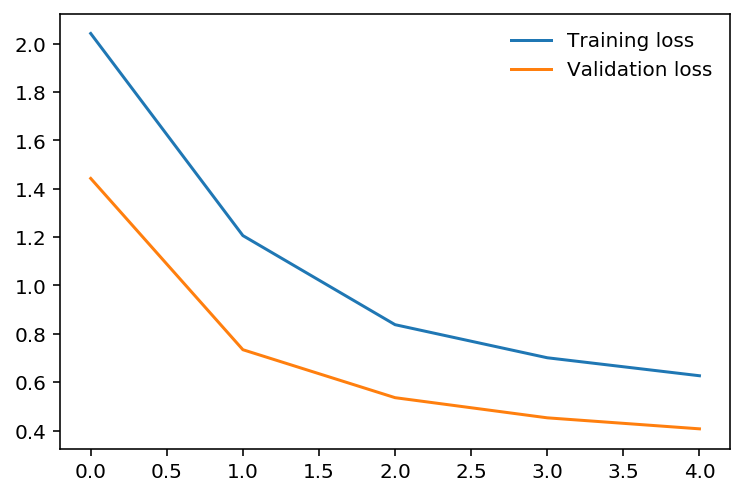

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

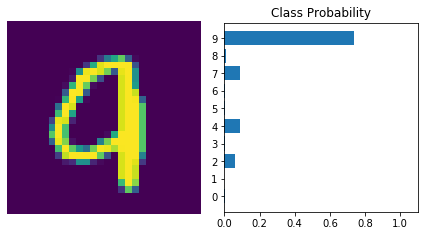

In [19]:
# Checking out predictions
import helper

images, labels = next(iter(trainloader))

img = images[1].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [24]:
print("Fashiion MNIST model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Fashiion MNIST model: 

 Sequential(
  (0): Dropout(p=0.25, inplace=False)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): LogSoftmax()
) 

The state dict keys: 

 odict_keys(['1.weight', '1.bias', '4.weight', '4.bias', '7.weight', '7.bias'])


In [28]:

torch.save(model.state_dict(), 'fashion_mnist_checkpoint.pth')
